### Validation schema

In [9]:
# linear algebra
import numpy as np

#working with data in table structers
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt


# working with files
import sys
import os
from pathlib import Path
import csv
import io

# to off warnings
import warnings
warnings.filterwarnings('ignore')

# validation schema 
import time
import sklearn
from sklearn.model_selection import train_test_split
from datetime import timedelta, datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# models
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
import catboost as cb

In [2]:
# # using ray engine for parallel calculation(for oprimization)
# %env MODIN_ENGINE=ray
# import modin.pandas as mpd

### Read data

In [3]:
%%time
# set the data path
train_test_data_path = Path('C:\Repository\DS-Intership-data') / 'train_test_data'
print(type(train_test_data_path))

# initiate dict for data
data = {}

# load data to dict
for file_path in train_test_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = pd.read_csv(file_path, index_col=0)
        print(file_path.stem)

<class 'pathlib.WindowsPath'>
submission_example
test_data
train_data
CPU times: total: 22.1 s
Wall time: 23 s


### Validation schema creation

In [4]:
"""
    The following indexes will be used:
        
        from train_data:
          date_block_num
          shop_id
          item_category_id
          item_id
          item_cnt_month
        
        from test_data:
            shop_id',
            'item_id',
            'ID'

    Concept:
        Apply expanding window validation (except last month - target of competition)
        Monthly predictions
"""

class Validation:
    def __init__(self,
                 train_data,
                 test_data,
                 submission_example,
                 metrics=['rmse'],
                 n_splits=5,
                 model=RandomForestRegressor(max_depth=1, n_estimators=1, random_state=42, n_jobs=-1),
                 params=None,
                 check_nans = True,
                 dropna = False,
                 check_infs = True,
                 validation_schema_plot=False
                ):
        self.train_data = train_data
        self.test_data = test_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.n_splits = n_splits
        self.model = model
        self.params = params
        self.tscv = TimeSeriesSplit(n_splits=self.n_splits)
    
        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_category_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_category_id',
                    'item_id',
                   ]).issubset(test_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"
        
        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.test_data = self.test_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
        if check_nans:
            assert self.test_data.isna().sum().sum() == 0, 'Test data have NaNs'
        if check_infs:
            assert np.isfinite(self.test_data).sum().sum() != 0, 'Test data have Infs'
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
            
        # Split to X and y
        self.X = self.train_data.drop(columns='item_cnt_month')
        self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
        # Validation process visualisation
        if validation_schema_plot:
            split_history = {
                'Step': ["Step"+str(i) for i in range(1, self.n_splits+1)],
                'Train Data': [], 
                'Validation Data': []
            }
            for train, val in self.tscv.split(self.train_data[['item_id', 'shop_id', 'item_cnt_month']]):    
                split_history['Train Data'].append(train.max()-train.min())
                split_history['Validation Data'].append(val.max()-val.min())
            df = pd.DataFrame(split_history)
            print(df)
            sns.set(style="whitegrid")
            plt.figure(figsize=(6, 5))
            sns.barplot(x='Step', y='Train Data', data=df, color='skyblue', label='Train Data')
            sns.barplot(x='Step', y='Validation Data', data=df, color='salmon', label='Validation Data', bottom=df['Train Data'])
            plt.title('Distribution of data for training and validation')
            plt.xlabel('Validation step')
            plt.ylabel('Data quantity')
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()
    
    def calculate_metrics(self, y_pred, y_true):
        rmse = mse(y_true, y_pred, squared=True)
        return rmse
    
    # Predict sales for target month (November 2015)
    def predict_target(self, predictions_by_ID = True):
        """
            Return target predictions in accordance with submission example
        """
        X_train, y_train = self.train_data.drop(columns=['item_cnt_month']),\
                           self.train_data.item_cnt_month
        X_test = self.test_data
        
        # train model
        model = self.model
        model.fit(X_train, y_train)
        if predictions_by_ID:
            result = X_test.join(pd.DataFrame(index=X_test.index, data=model.predict(X_test.values),\
                                           columns=['item_cnt_month']))\
                                                [['item_id', 'shop_id', 'item_cnt_month']].\
                                merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                    .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
            result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
            return result
        else:
            return model.predict(X_val) 
    
    def evaluate(self, predictions_by_ID = False):
        
        eval_report = {}
        
        # Evaluation loop
        step = 0
        for train, val in self.tscv.split(self.y):
            
            # Initialize steps and timer
            step += 1
            ts = time.time()

            # Split data step
            
            y_train, y_val = self.y.iloc[train].item_cnt_month, self.y.iloc[val].item_cnt_month
            X_train, X_val = self.X.iloc[train], self.X.iloc[val]            

            # Train step
            rng = np.random.RandomState(42)
            model = self.model
            
            if isinstance(model, sklearn.ensemble._forest.RandomForestRegressor):
                model = self.model
                model.fit(X_train, y_train)
                y_pred_val = model.predict(X_val)
                y_pred_train = model.predict(X_train)
                val_error = [self.calculate_metrics(y_pred_val, y_val)]
                train_error = [self.calculate_metrics(y_pred_train, y_train)]
                
            else:
                if isinstance(model, cb.core.CatBoostRegressor):
                    # Split
                    train_data = cb.Pool(X_train, label=y_train)
                    valid_data = cb.Pool(X_val, label=y_val)

                    # Train 
                    model.fit(train_data, eval_set=valid_data)

                    # Get error report
                    evals_result = model.get_evals_result()
                    train_error = evals_result['learn']['RMSE']
                    val_error = evals_result['validation']['RMSE']

                if isinstance(model, XGBRegressor):
                    model = self.model
                    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_train, y_train), (X_val, y_val)], verbose=50)

                    # Get error report
                    evals_result = model.evals_result()
                    train_error = evals_result['validation_0']['rmse']
                    val_error = evals_result['validation_1']['rmse']

                if isinstance(model, lgb.sklearn.LGBMRegressor):
                    assert self.params is not None, "params is None"
                    train_data = lgb.Dataset(X_train, label=y_train)
                    valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
                    model.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)])

                    # Get error report
                    evals_result = model.evals_result_
                    train_error = evals_result['training']['l2']
                    val_error = evals_result['valid_0']['l2']
                    
                # Visualize
                plt.figure(figsize=(10, 6))
                plt.plot(train_error, label='Train Error')
                plt.plot(val_error, label='Validation Error')
                plt.xlabel('Iterations')
                plt.ylabel('RMSE Error')
                plt.legend()
                plt.title(f'{type(model)} Training and Validation Error')
                plt.show()
                
            # Calculate time required for step
            time_info = time.time() - ts
            
            # Metrics calucaltion step
            eval_report["step"+str(step)] = {"Train/Validation error": [train_error[-1], val_error[-1]]}
            eval_report["step"+str(step)]["Train/Validation limits"] = f"TRAIN: from {train.min()} to  {train.max()}  (size: {train.max() - train.min()} ) " + f"VALIDATION: from {val.min()} to  {val.max()}  (size: {val.max() - val.min()} )"
            eval_report["step"+str(step)]["Time for step"]  = f"{time_info} s"
            eval_report["step"+str(step)]["__________________"] = "_________________________________________________________________________________"
        return eval_report     

Data is not sorted by time (5616 rows), it will be further sorted automatically
     Step  Train Data  Validation Data
0   Step1      198979           198977
1   Step2      397957           198977
2   Step3      596935           198977
3   Step4      795913           198977
4   Step5      994891           198977
5   Step6     1193869           198977
6   Step7     1392847           198977
7   Step8     1591825           198977
8   Step9     1790803           198977
9  Step10     1989781           198977


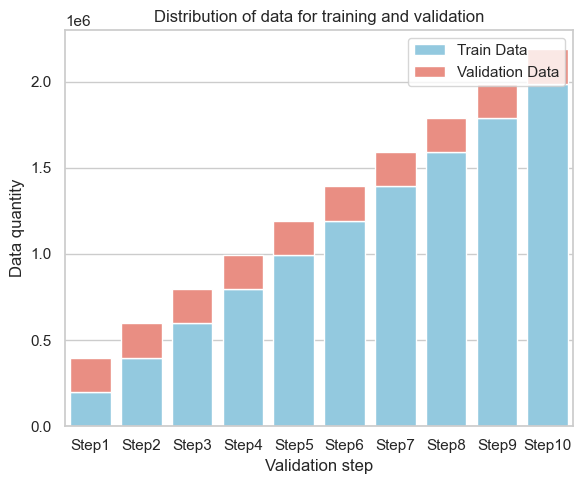

CPU times: total: 1.47 s
Wall time: 1.63 s


In [5]:
%%time
test_validation_class = Validation(
                 train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 n_splits=10,
                 model = RandomForestRegressor(max_depth=1, n_estimators=1, random_state=42, n_jobs=-1),
                 check_nans=True,
                 dropna = True,
                 validation_schema_plot=True
                )

In [6]:
%%time
test_validation_class.evaluate()

CPU times: total: 9.62 s
Wall time: 10.1 s


{'step1': {'Train/Validation error': [0.9526031628668, 1.3181425886531049],
  'Train/Validation limits': 'TRAIN: from 0 to  198979  (size: 198979 ) VALIDATION: from 198980 to  397957  (size: 198977 )',
  'Time for step': '0.20054078102111816 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation error': [1.0844371245438509, 8.754321124660649],
  'Train/Validation limits': 'TRAIN: from 0 to  397957  (size: 397957 ) VALIDATION: from 397958 to  596935  (size: 198977 )',
  'Time for step': '0.3458380699157715 s',
  '__________________': '_________________________________________________________________________________'},
 'step3': {'Train/Validation error': [2.3053655781907163, 5.8174809044426254],
  'Train/Validation limits': 'TRAIN: from 0 to  596935  (size: 596935 ) VALIDATION: from 596936 to  795913  (size: 198977 )',
  'Time for step': '0.5262799263000488 s',
  '__________________': '______________

In [7]:
%%time
test_validation_class.predict_target()

CPU times: total: 1.66 s
Wall time: 1.8 s


,ID,item_cnt_month
0,0,0.30
1,1,0.00
2,2,0.00
3,3,0.00
4,4,0.00
...,...,...
214195,214195,0.00
214196,214196,0.00
214197,214197,0.30
214198,214198,0.00


### Learn models

##### Random Forest Regressor

In [8]:
%%time
random_forest_regression = Validation(
                                 train_data=data['train_data'],
                                 test_data=data['test_data'],
                                 submission_example=data['submission_example'],
                                 n_splits=10,
                                 model = RandomForestRegressor(max_depth=4, n_estimators=25, random_state=42, n_jobs=-1),
                                 check_nans=True,
                                 dropna = True
                           )

Data is not sorted by time (5616 rows), it will be further sorted automatically
CPU times: total: 984 ms
Wall time: 1.11 s


In [9]:
%%time
random_forest_report = random_forest_regression.evaluate()
random_forest_report

CPU times: total: 25min 32s
Wall time: 2min 40s


{'step1': {'Train/Validation error': [0.4942056495370522, 0.7582751238585196],
  'Train/Validation limits': 'TRAIN: from 0 to  198979  (size: 198979 ) VALIDATION: from 198980 to  397957  (size: 198977 )',
  'Time for step': '1.5185959339141846 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation error': [0.581018391029274, 3.568883441601405],
  'Train/Validation limits': 'TRAIN: from 0 to  397957  (size: 397957 ) VALIDATION: from 397958 to  596935  (size: 198977 )',
  'Time for step': '3.8621790409088135 s',
  '__________________': '_________________________________________________________________________________'},
 'step3': {'Train/Validation error': [0.6700329289487627, 1.776298249628479],
  'Train/Validation limits': 'TRAIN: from 0 to  596935  (size: 596935 ) VALIDATION: from 596936 to  795913  (size: 198977 )',
  'Time for step': '6.791365623474121 s',
  '__________________': '_______________

In [10]:
%%time
RandomForest_regression_submission = random_forest_regression.predict_target()

CPU times: total: 6min 3s
Wall time: 37.3 s


##### XGboost

In [11]:
%%time
XGB_regression = Validation(
                     train_data=data['train_data'],
                     test_data=data['test_data'],
                     submission_example=data['submission_example'],
                     n_splits=10,
                     model = XGBRegressor(),
                     check_nans=False,
                     dropna = False
                 ) 

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 3.64 s
Wall time: 4.17 s


[0]	validation_0-rmse:1.72228	validation_1-rmse:1.84158
[11]	validation_0-rmse:1.48689	validation_1-rmse:2.07034


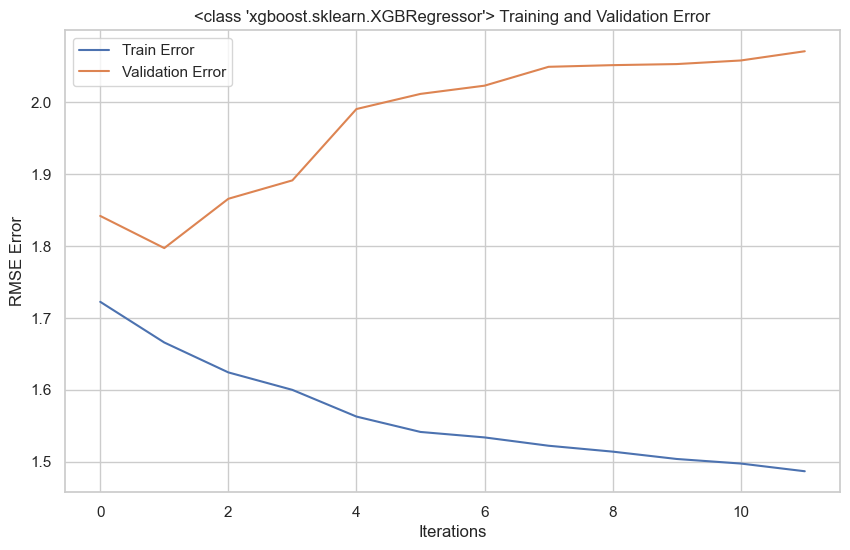

[0]	validation_0-rmse:1.68710	validation_1-rmse:1.81972
[23]	validation_0-rmse:1.30410	validation_1-rmse:1.44128


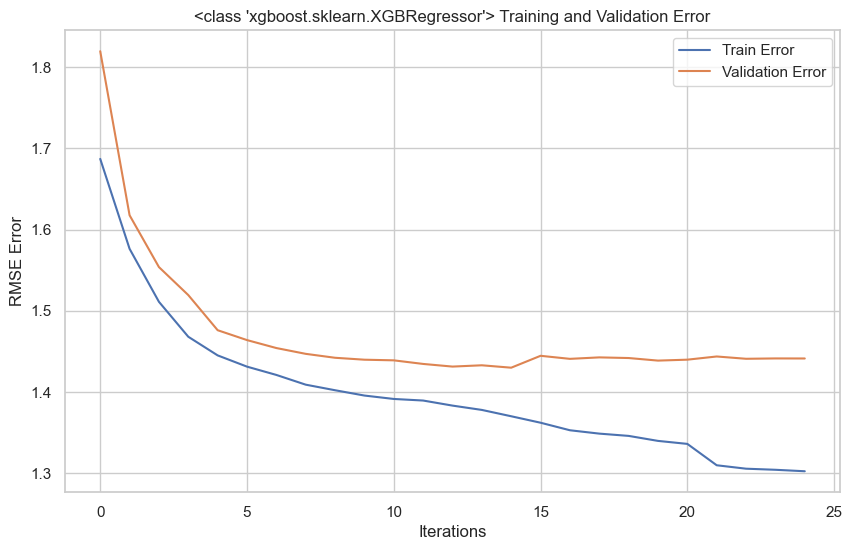

[0]	validation_0-rmse:1.73755	validation_1-rmse:2.22311
[46]	validation_0-rmse:1.21218	validation_1-rmse:1.68873


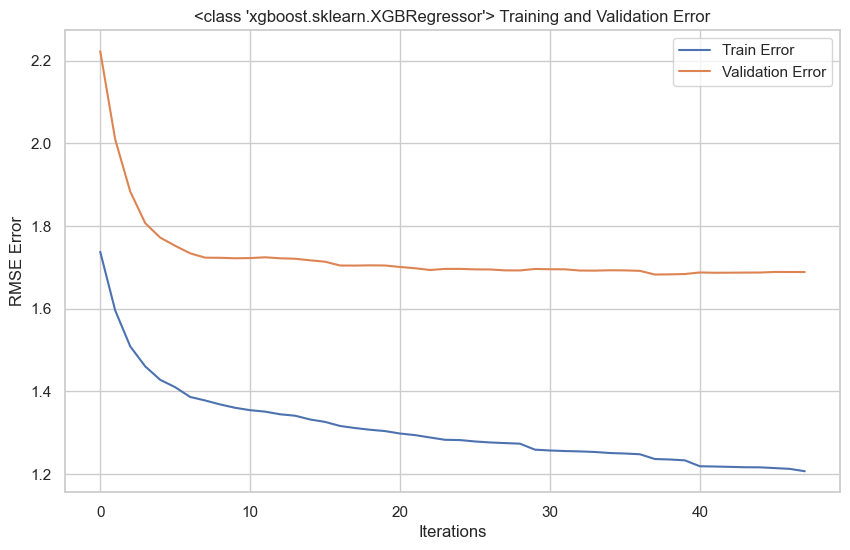

[0]	validation_0-rmse:1.85817	validation_1-rmse:2.01847
[33]	validation_0-rmse:1.29693	validation_1-rmse:1.56740


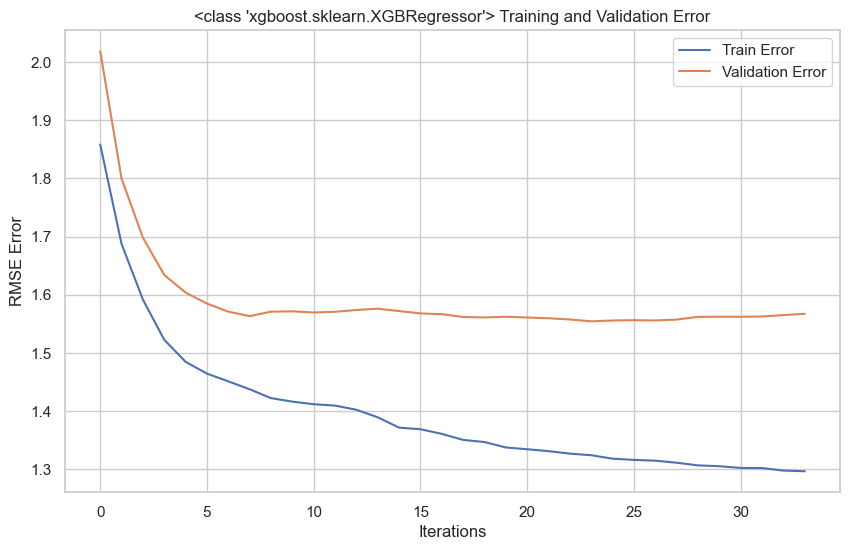

[0]	validation_0-rmse:1.89305	validation_1-rmse:1.90231
[16]	validation_0-rmse:1.39285	validation_1-rmse:1.42543


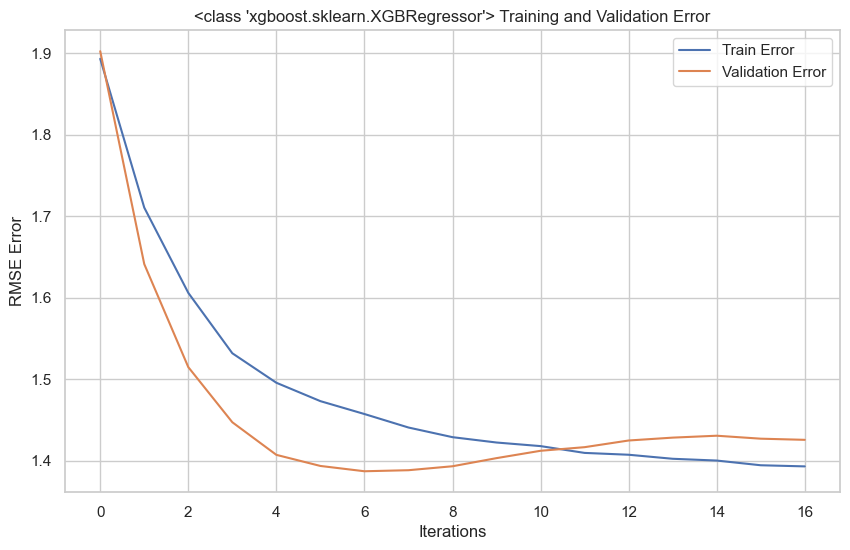

[0]	validation_0-rmse:1.90184	validation_1-rmse:1.53617
[45]	validation_0-rmse:1.26679	validation_1-rmse:1.01747


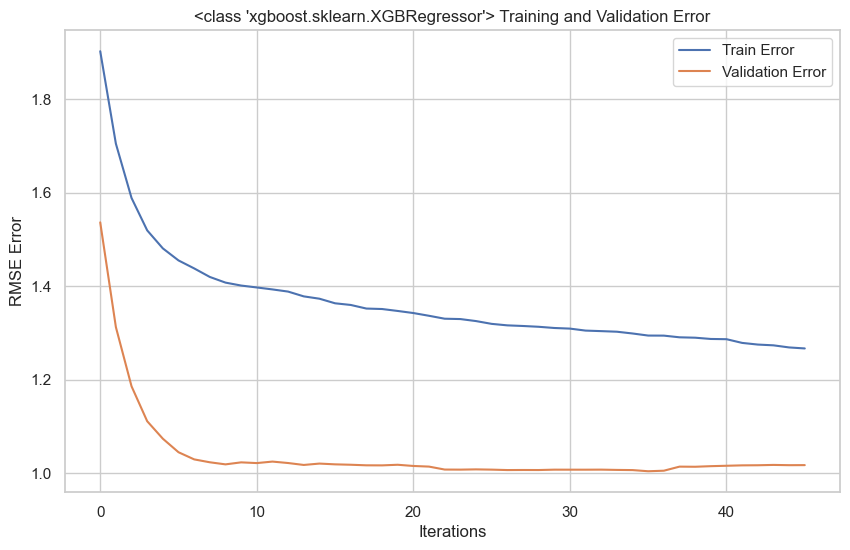

[0]	validation_0-rmse:1.85230	validation_1-rmse:2.27751
[50]	validation_0-rmse:1.23779	validation_1-rmse:1.64087
[62]	validation_0-rmse:1.21953	validation_1-rmse:1.65250


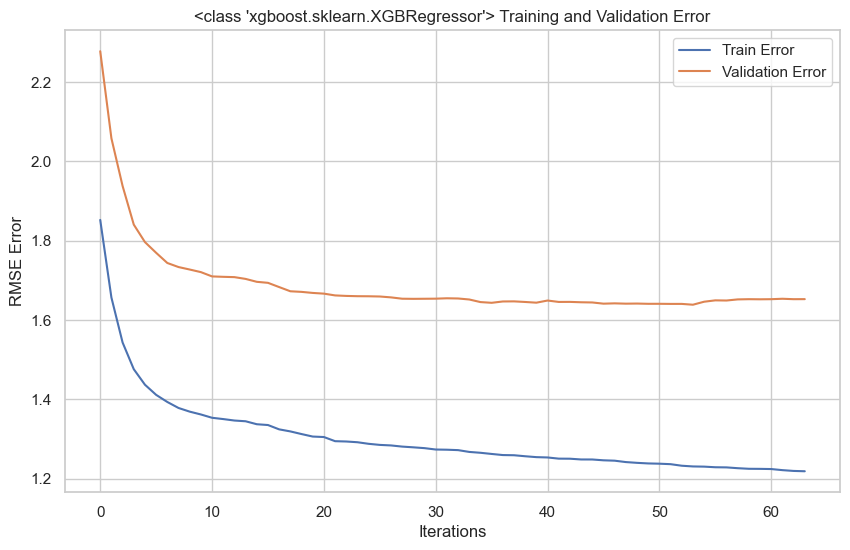

[0]	validation_0-rmse:1.89946	validation_1-rmse:2.08482
[17]	validation_0-rmse:1.35528	validation_1-rmse:1.56310


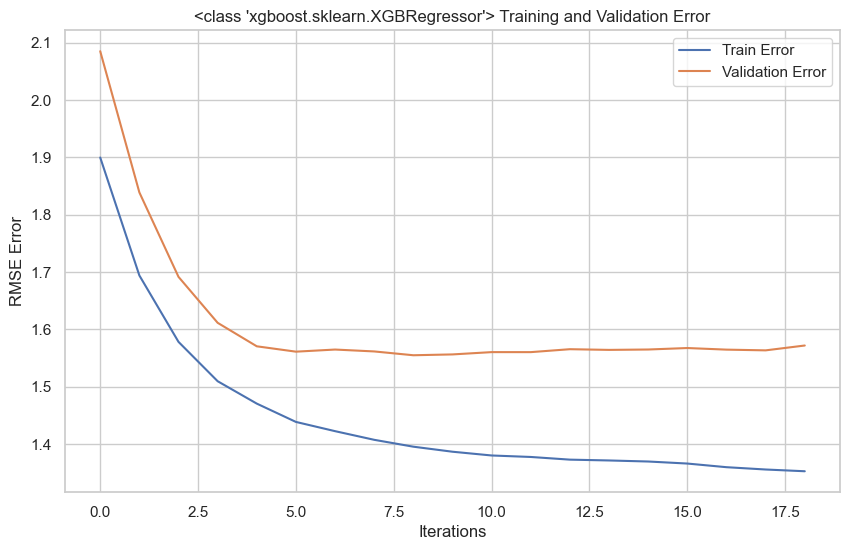

[0]	validation_0-rmse:1.92409	validation_1-rmse:1.66206
[36]	validation_0-rmse:1.29836	validation_1-rmse:1.48290


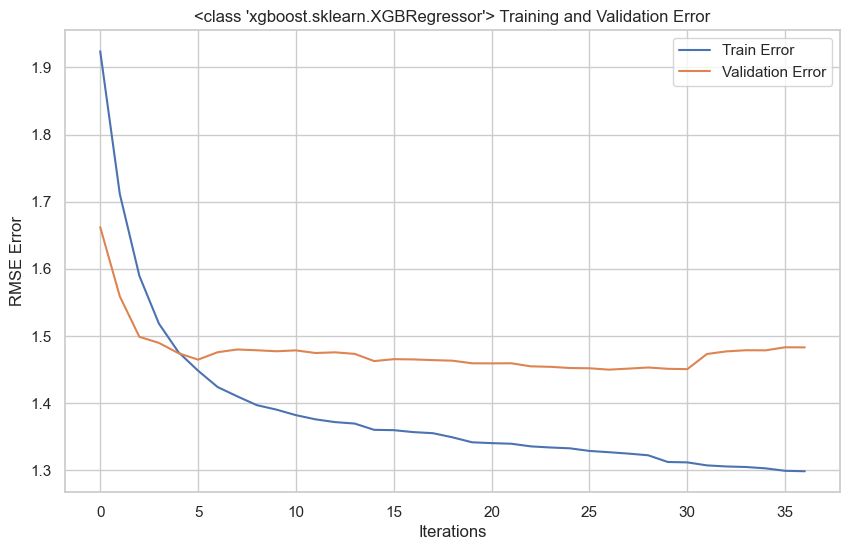

[0]	validation_0-rmse:1.89910	validation_1-rmse:1.91876
[50]	validation_0-rmse:1.26391	validation_1-rmse:1.28963
[64]	validation_0-rmse:1.24553	validation_1-rmse:1.28754


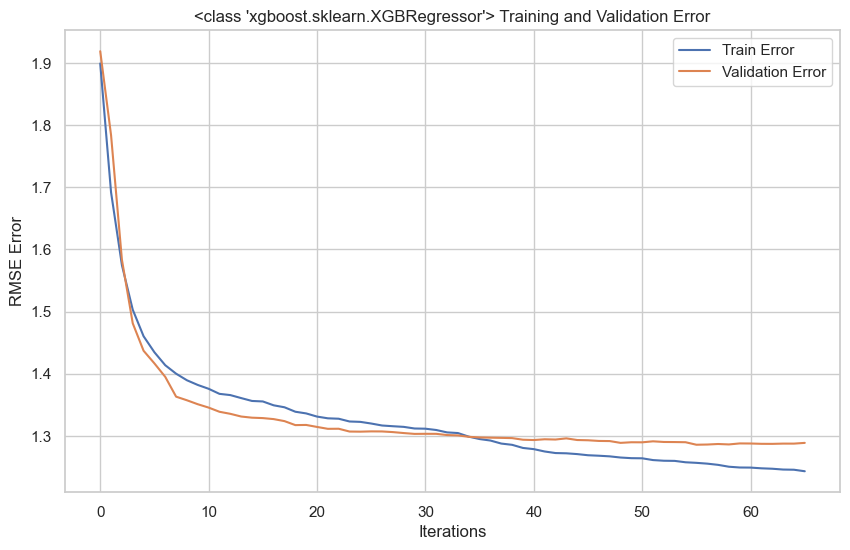

CPU times: total: 44min 24s
Wall time: 4min 42s


{'step1': {'Train/Validation error': [1.4868918189157152, 2.070340846143744],
  'Train/Validation limits': 'TRAIN: from 0 to  991183  (size: 991183 ) VALIDATION: from 991184 to  1982357  (size: 991173 )',
  'Time for step': '6.401339530944824 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation error': [1.3022922557580847, 1.4412217039733384],
  'Train/Validation limits': 'TRAIN: from 0 to  1982357  (size: 1982357 ) VALIDATION: from 1982358 to  2973531  (size: 991173 )',
  'Time for step': '8.891608238220215 s',
  '__________________': '_________________________________________________________________________________'},
 'step3': {'Train/Validation error': [1.2063998596580978, 1.6886853698392164],
  'Train/Validation limits': 'TRAIN: from 0 to  2973531  (size: 2973531 ) VALIDATION: from 2973532 to  3964705  (size: 991173 )',
  'Time for step': '18.216543674468994 s',
  '__________________': '_____

In [12]:
%%time
XGB_report = XGB_regression.evaluate()
XGB_report

In [13]:
%%time
XGB_regression_submission = XGB_regression.predict_target()

CPU times: total: 7min 41s
Wall time: 54.3 s


##### LightGBM

In [14]:
%%time

params = {
    "objective": "regression",  
    "metric": "rmse",           
    "num_leaves": 31,           
    "learning_rate": 0.05,      
    "verbosity": 1            
}

LightGBM_regression = Validation(
                     train_data=data['train_data'],
                     test_data=data['test_data'],
                     submission_example=data['submission_example'],
                     n_splits=10,
                     model = lgb.LGBMRegressor(),
                     params=params,
                     check_nans=False,
                     dropna = False
                 ) 

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 5.2 s
Wall time: 8.35 s


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1910
[LightGBM] [Info] Number of data points in the train set: 991184, number of used features: 26
[LightGBM] [Info] Start training from score 0.370565


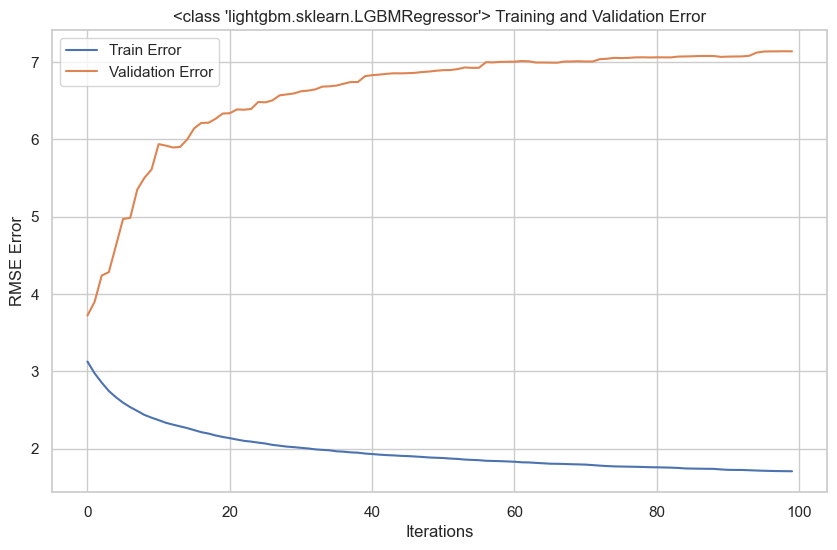

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2957
[LightGBM] [Info] Number of data points in the train set: 1982358, number of used features: 30
[LightGBM] [Info] Start training from score 0.329794


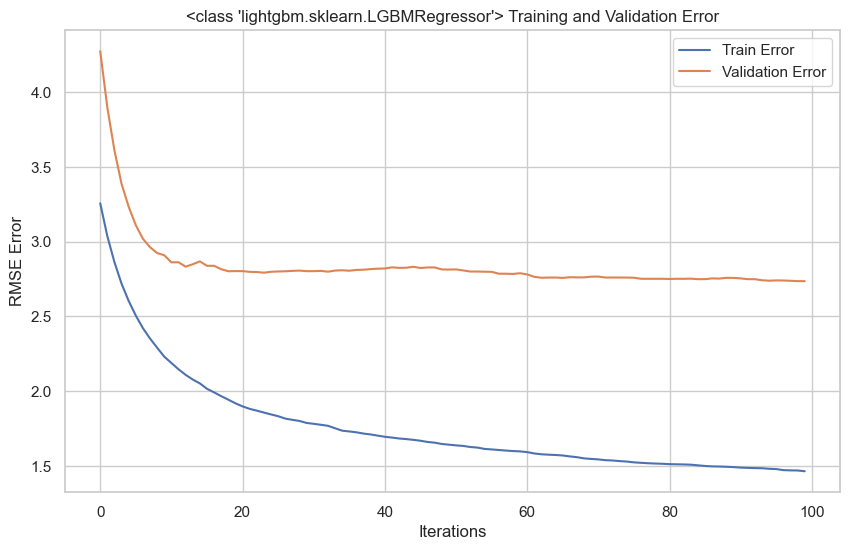

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3185
[LightGBM] [Info] Number of data points in the train set: 2973532, number of used features: 30
[LightGBM] [Info] Start training from score 0.325225


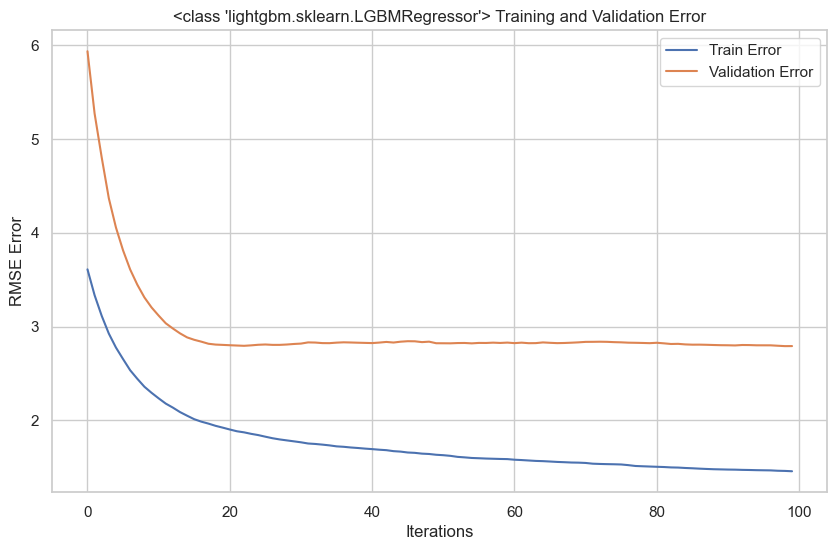

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3313
[LightGBM] [Info] Number of data points in the train set: 3964706, number of used features: 30
[LightGBM] [Info] Start training from score 0.326452


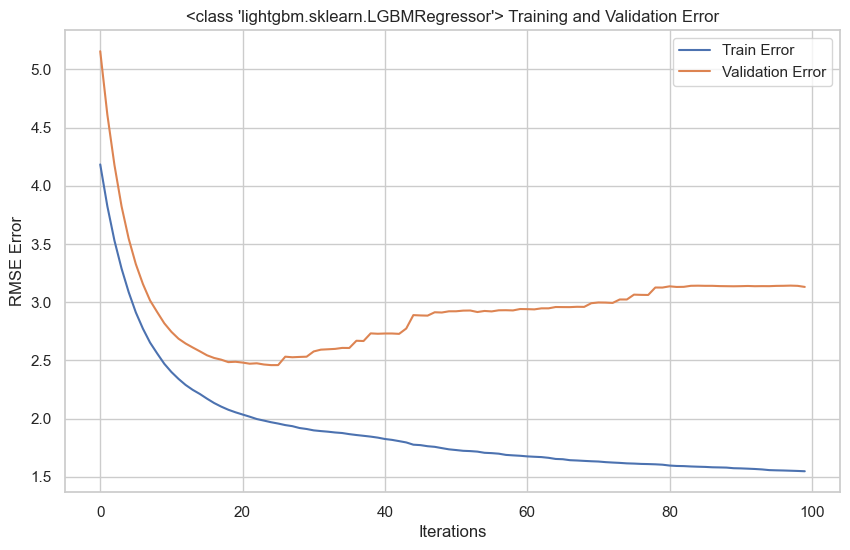

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.406928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3407
[LightGBM] [Info] Number of data points in the train set: 4955880, number of used features: 32
[LightGBM] [Info] Start training from score 0.339508


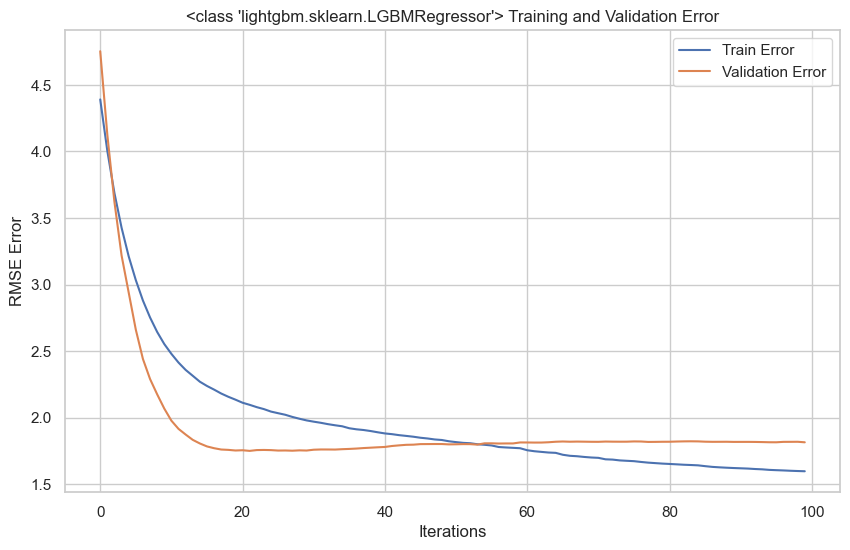

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.551500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3450
[LightGBM] [Info] Number of data points in the train set: 5947054, number of used features: 32
[LightGBM] [Info] Start training from score 0.333590


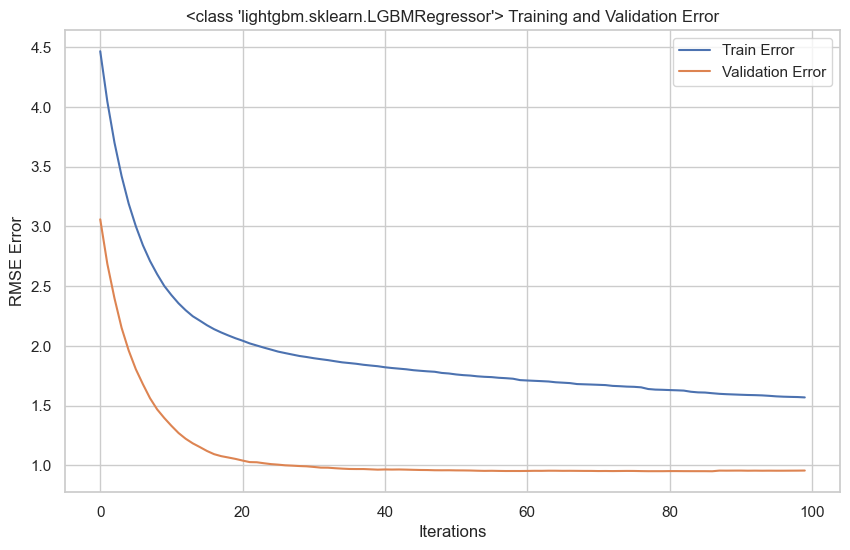

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.337597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3493
[LightGBM] [Info] Number of data points in the train set: 6938228, number of used features: 32
[LightGBM] [Info] Start training from score 0.324908


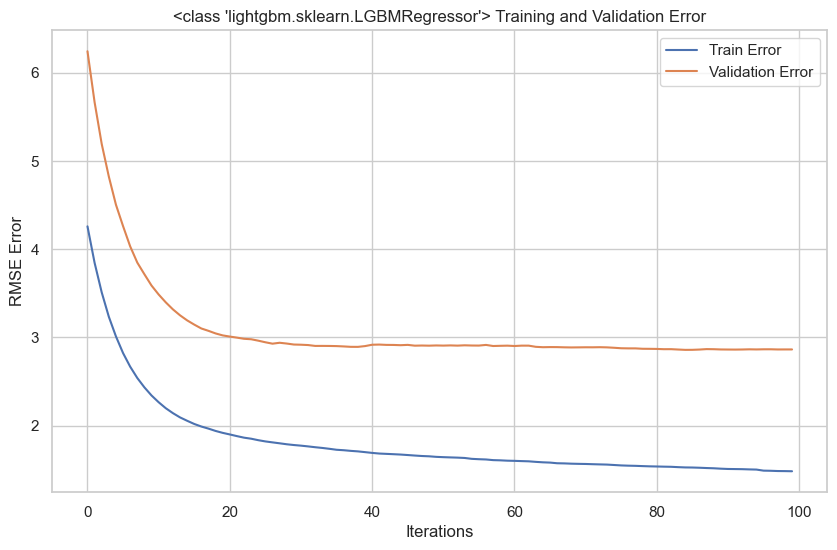

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.375621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3563
[LightGBM] [Info] Number of data points in the train set: 7929402, number of used features: 32
[LightGBM] [Info] Start training from score 0.326869


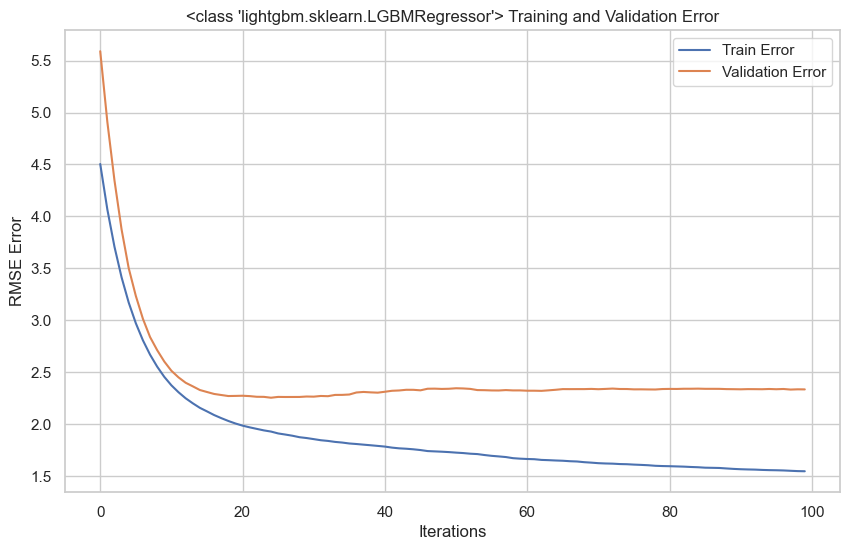

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.484301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3598
[LightGBM] [Info] Number of data points in the train set: 8920576, number of used features: 32
[LightGBM] [Info] Start training from score 0.331737


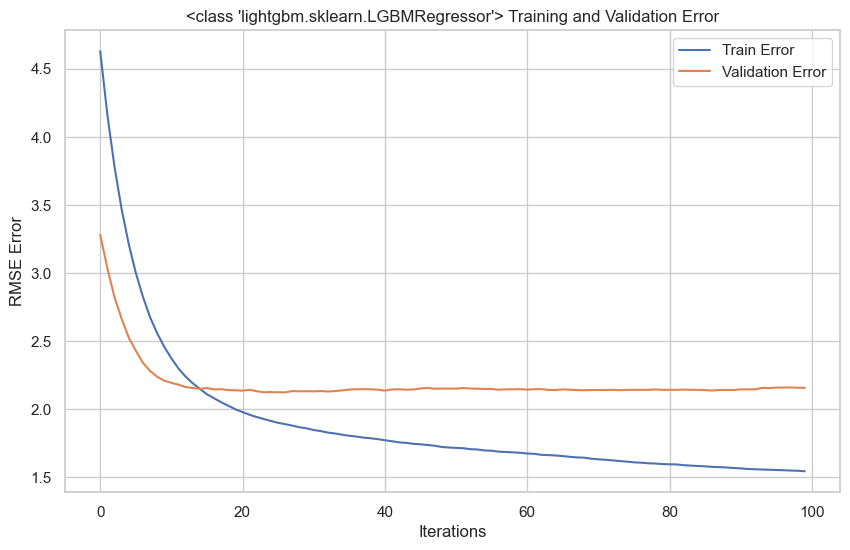

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.795466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3634
[LightGBM] [Info] Number of data points in the train set: 9911750, number of used features: 32
[LightGBM] [Info] Start training from score 0.325746


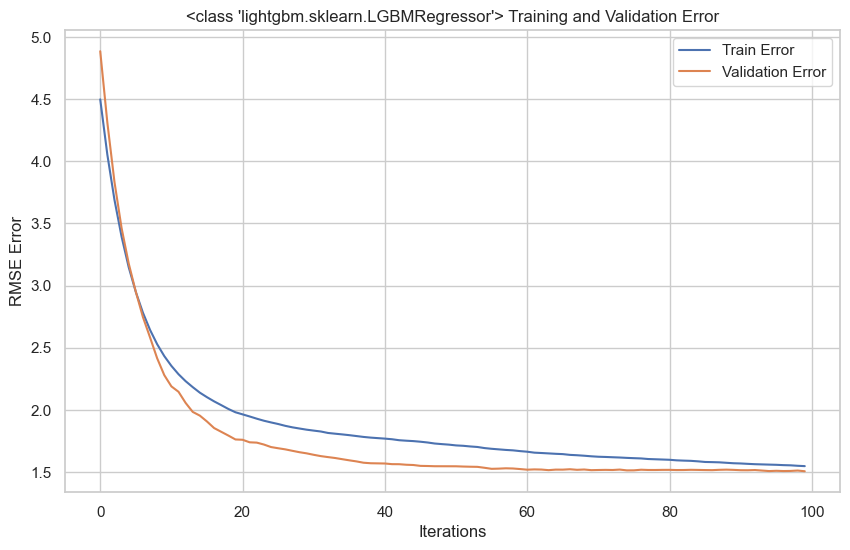

CPU times: total: 13min 33s
Wall time: 3min 7s


{'step1': {'Train/Validation error': [1.707223579804017, 7.139215624487469],
  'Train/Validation limits': 'TRAIN: from 0 to  991183  (size: 991183 ) VALIDATION: from 991184 to  1982357  (size: 991173 )',
  'Time for step': '7.112590312957764 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation error': [1.4643681455671245, 2.7364344558496163],
  'Train/Validation limits': 'TRAIN: from 0 to  1982357  (size: 1982357 ) VALIDATION: from 1982358 to  2973531  (size: 991173 )',
  'Time for step': '8.52147650718689 s',
  '__________________': '_________________________________________________________________________________'},
 'step3': {'Train/Validation error': [1.4589277146567636, 2.7928177185324805],
  'Train/Validation limits': 'TRAIN: from 0 to  2973531  (size: 2973531 ) VALIDATION: from 2973532 to  3964705  (size: 991173 )',
  'Time for step': '10.898046970367432 s',
  '__________________': '_______

In [15]:
%%time
LightGBM_report = LightGBM_regression.evaluate()
LightGBM_report

In [16]:
%%time
LightGBM_regression_submission = LightGBM_regression.predict_target()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.694823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3677
[LightGBM] [Info] Number of data points in the train set: 10902924, number of used features: 32
[LightGBM] [Info] Start training from score 0.322979
CPU times: total: 2min 22s
Wall time: 39.4 s


##### Catboost

In [17]:
%%time
catboost_regression = Validation(
                 train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 n_splits=10,
                 model = cb.CatBoostRegressor(iterations=35, verbose=100),
                 check_nans=False,
                 dropna = False
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 3.88 s
Wall time: 6.29 s


Learning rate set to 0.5
0:	learn: 1.7121695	test: 1.7688371	best: 1.7688371 (0)	total: 197ms	remaining: 6.71s
34:	learn: 1.4494278	test: 1.9583993	best: 1.7109676 (1)	total: 2.13s	remaining: 0us

bestTest = 1.710967648
bestIteration = 1

Shrink model to first 2 iterations.


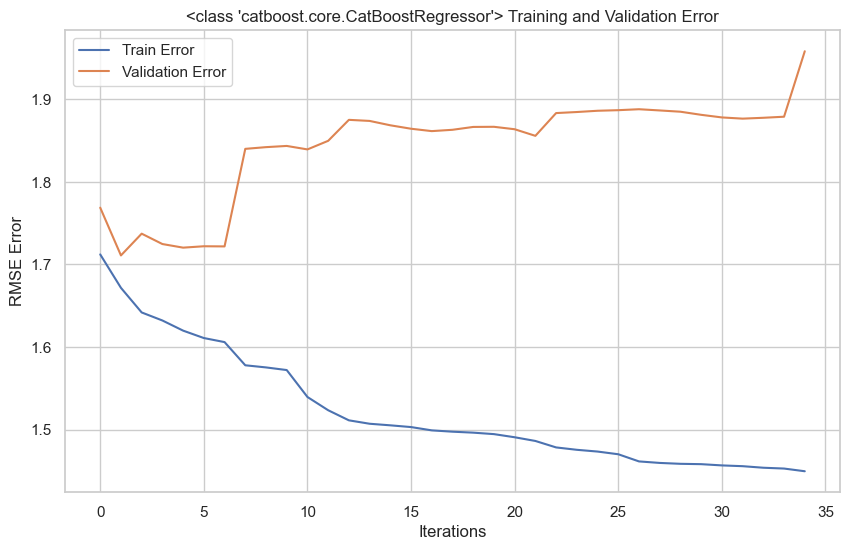

Learning rate set to 0.5
0:	learn: 1.6698623	test: 1.7114135	best: 1.7114135 (0)	total: 128ms	remaining: 4.36s
34:	learn: 1.3357588	test: 1.4899624	best: 1.4716628 (3)	total: 4.15s	remaining: 0us

bestTest = 1.471662758
bestIteration = 3

Shrink model to first 4 iterations.


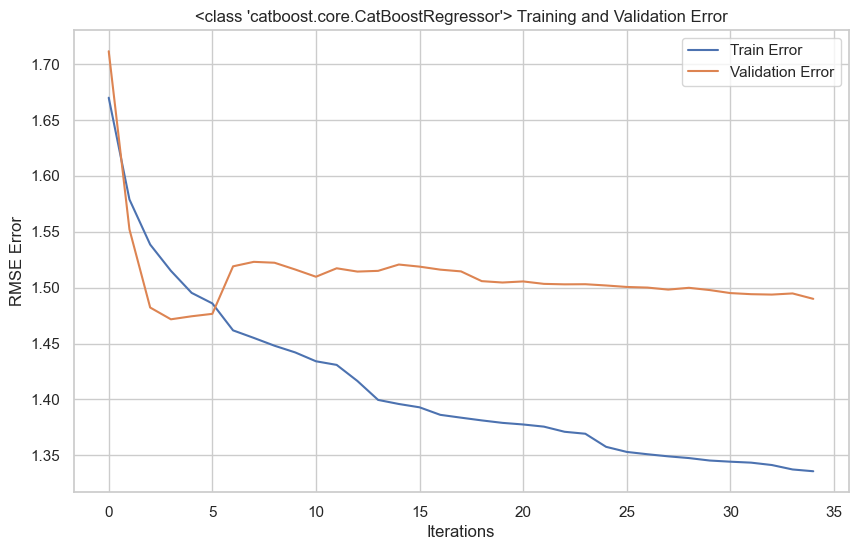

Learning rate set to 0.5
0:	learn: 1.6723583	test: 2.0475050	best: 2.0475050 (0)	total: 170ms	remaining: 5.79s
34:	learn: 1.3046722	test: 1.6681906	best: 1.6681906 (34)	total: 5.69s	remaining: 0us

bestTest = 1.668190551
bestIteration = 34



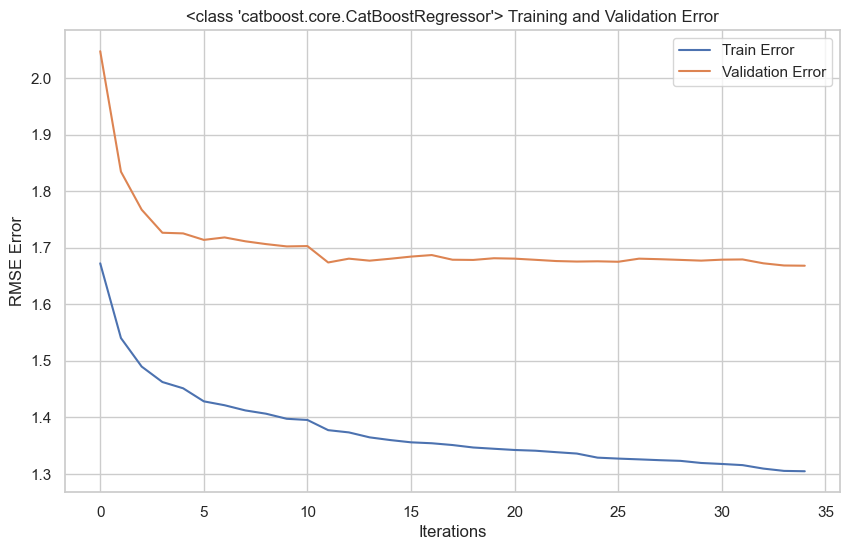

Learning rate set to 0.5
0:	learn: 1.7746947	test: 1.8914874	best: 1.8914874 (0)	total: 209ms	remaining: 7.09s
34:	learn: 1.3647855	test: 1.7576054	best: 1.5798338 (6)	total: 7.24s	remaining: 0us

bestTest = 1.579833789
bestIteration = 6

Shrink model to first 7 iterations.


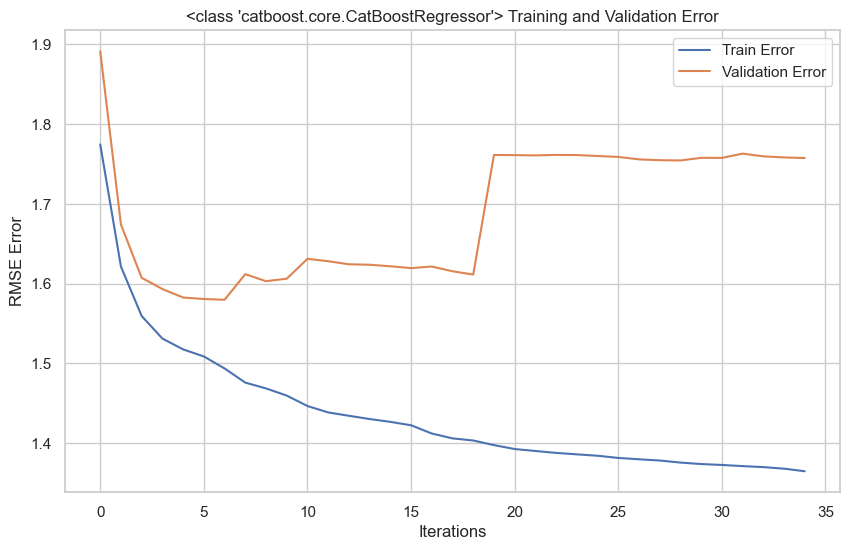

Learning rate set to 0.5
0:	learn: 1.7942602	test: 1.7414596	best: 1.7414596 (0)	total: 221ms	remaining: 7.52s
34:	learn: 1.3820965	test: 1.4371545	best: 1.3566180 (4)	total: 9.13s	remaining: 0us

bestTest = 1.356617968
bestIteration = 4

Shrink model to first 5 iterations.


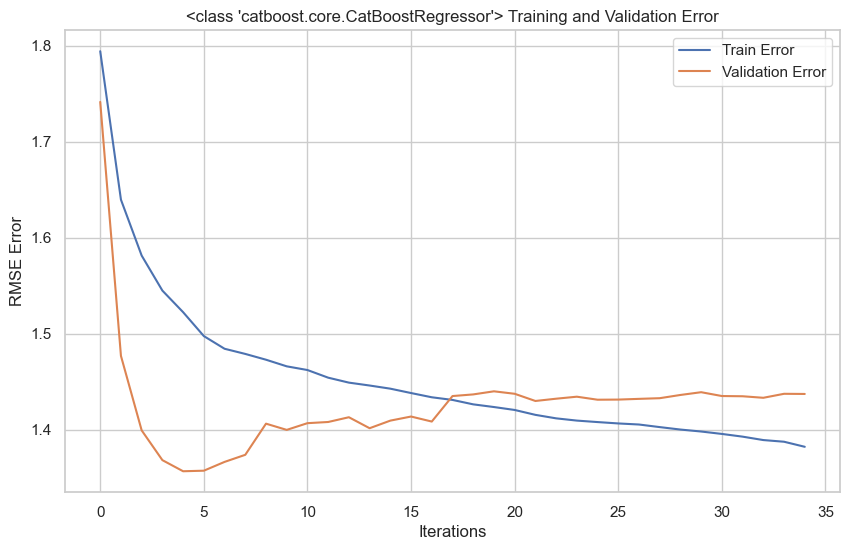

Learning rate set to 0.5
0:	learn: 1.7802912	test: 1.3661916	best: 1.3661916 (0)	total: 305ms	remaining: 10.4s
34:	learn: 1.3650792	test: 0.9781000	best: 0.9760553 (33)	total: 10.8s	remaining: 0us

bestTest = 0.9760552804
bestIteration = 33

Shrink model to first 34 iterations.


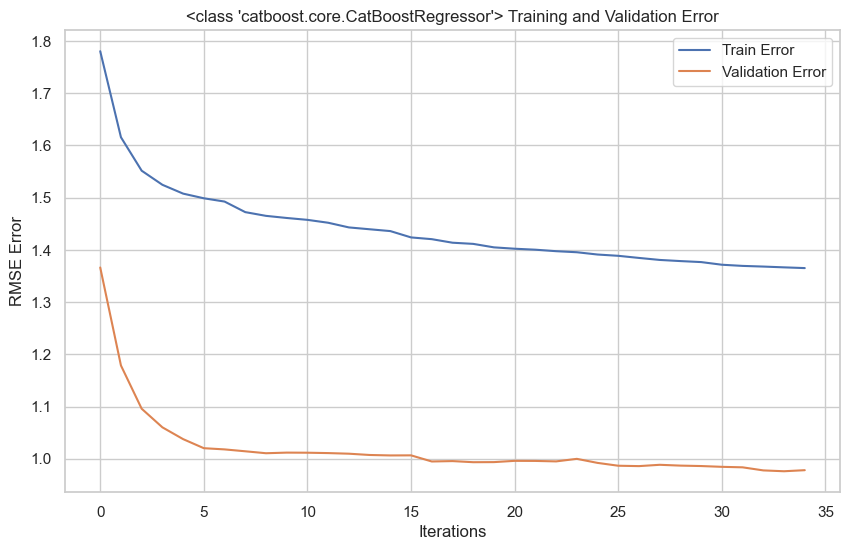

Learning rate set to 0.5
0:	learn: 1.7232471	test: 2.0952159	best: 2.0952159 (0)	total: 316ms	remaining: 10.8s
34:	learn: 1.3122771	test: 1.6586778	best: 1.6586778 (34)	total: 12s	remaining: 0us

bestTest = 1.65867779
bestIteration = 34



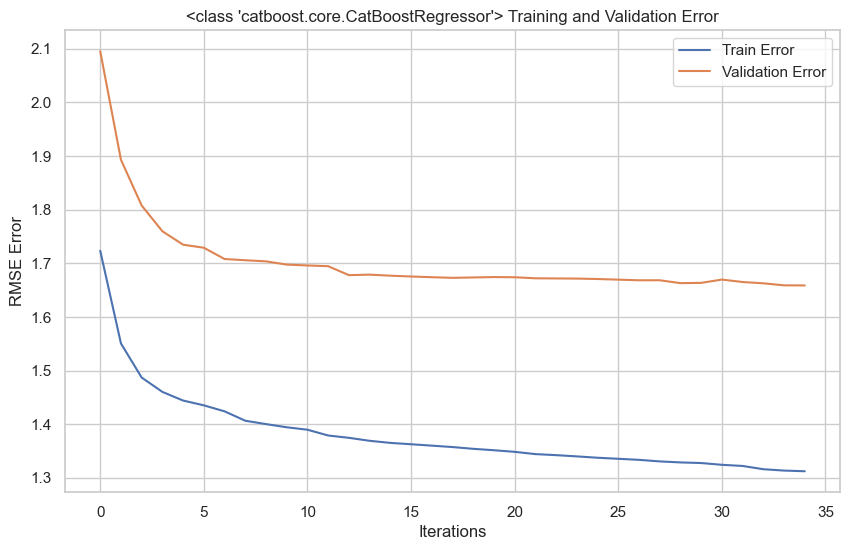

Learning rate set to 0.5
0:	learn: 1.7671263	test: 1.8776558	best: 1.8776558 (0)	total: 355ms	remaining: 12.1s
34:	learn: 1.3459135	test: 1.4917629	best: 1.4917629 (34)	total: 14.6s	remaining: 0us

bestTest = 1.491762856
bestIteration = 34



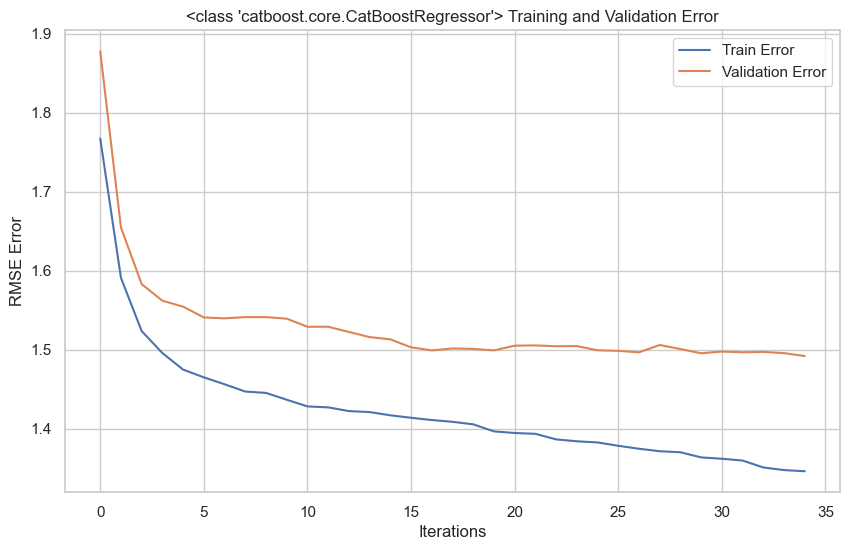

Learning rate set to 0.5
0:	learn: 1.7863630	test: 1.6194723	best: 1.6194723 (0)	total: 368ms	remaining: 12.5s
34:	learn: 1.3325607	test: 1.4822256	best: 1.4597078 (14)	total: 15.5s	remaining: 0us

bestTest = 1.45970778
bestIteration = 14

Shrink model to first 15 iterations.


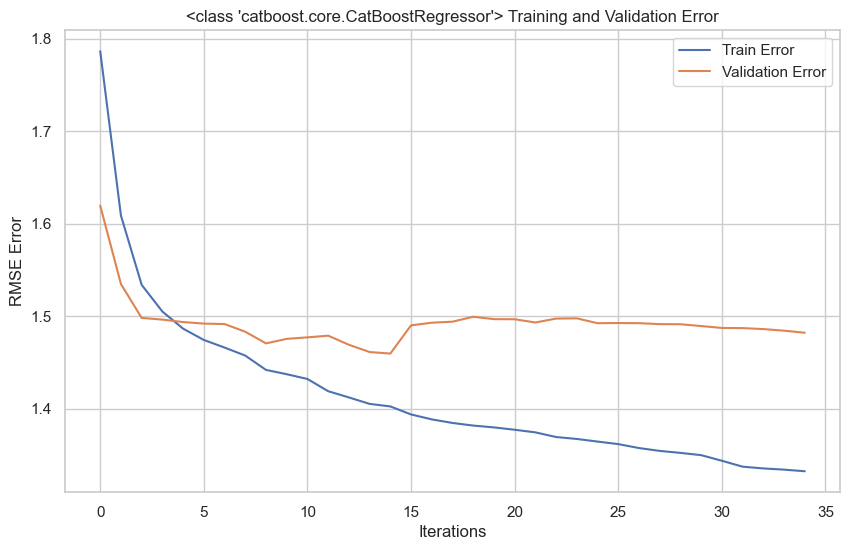

Learning rate set to 0.5
0:	learn: 1.7716844	test: 1.7814963	best: 1.7814963 (0)	total: 409ms	remaining: 13.9s
34:	learn: 1.3337308	test: 1.2403151	best: 1.2392298 (33)	total: 17.3s	remaining: 0us

bestTest = 1.23922984
bestIteration = 33

Shrink model to first 34 iterations.


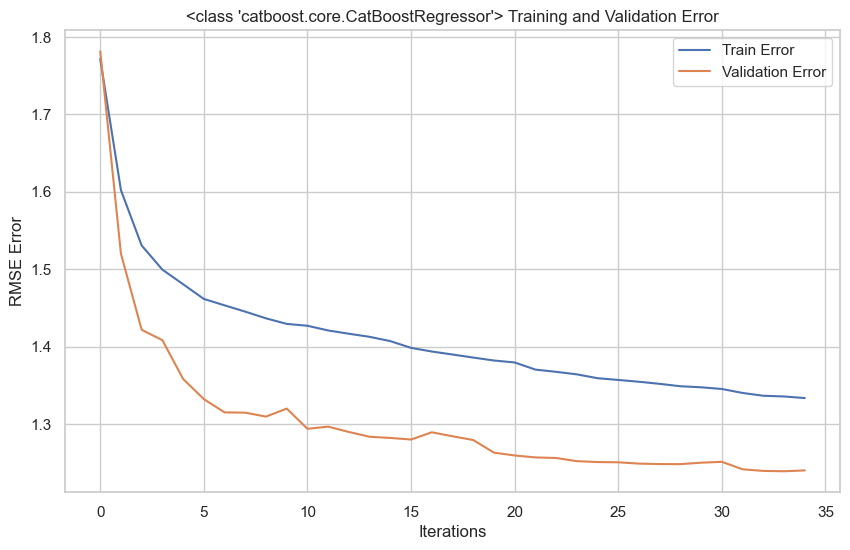

CPU times: total: 9min 24s
Wall time: 2min 4s


{'step1': {'Train/Validation error': [1.449427818291677, 1.9583993202305716],
  'Train/Validation limits': 'TRAIN: from 0 to  991183  (size: 991183 ) VALIDATION: from 991184 to  1982357  (size: 991173 )',
  'Time for step': '3.5985496044158936 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation error': [1.3357587552191712, 1.489962422032813],
  'Train/Validation limits': 'TRAIN: from 0 to  1982357  (size: 1982357 ) VALIDATION: from 1982358 to  2973531  (size: 991173 )',
  'Time for step': '5.613178014755249 s',
  '__________________': '_________________________________________________________________________________'},
 'step3': {'Train/Validation error': [1.3046721510066381, 1.668190550982771],
  'Train/Validation limits': 'TRAIN: from 0 to  2973531  (size: 2973531 ) VALIDATION: from 2973532 to  3964705  (size: 991173 )',
  'Time for step': '7.403900861740112 s',
  '__________________': '_______

In [18]:
%%time
CatBoost_report = catboost_regression.evaluate()
CatBoost_report

In [19]:
CatBoost_regression_submission = catboost_regression.predict_target()

Learning rate set to 0.5
0:	learn: 1.7723878	total: 515ms	remaining: 17.5s
34:	learn: 1.3097262	total: 18.9s	remaining: 0us


### Сomparison of models based on validation results

In [29]:
n_steps = 10

scores = pd.MultiIndex.from_product([["step " + str(i) for i in range(1, n_steps+1)],
                                  ['train_error', 'validation_error']],
                                 names=['Steps', 'RMSE'])
models = ['RandomForest', 'XGB', 'LightGBM', 'CatBoost']
df = pd.DataFrame('-', scores, models)

steps =  ["step" + str(i) for i in range(1, n_steps+1)]
reports = {'RandomForest': random_forest_report,
           'XGB':XGB_report,
           'LightGBM':LightGBM_report,
           'CatBoost':CatBoost_report
          }
for model, report in reports.items():
    temp = []
    for step in steps:
        temp.append(report[step]['Train/Validation error'][0])
        temp.append(report[step]['Train/Validation error'][1])
    df[model] = temp
df

RandomForest  XGB  LightGBM  CatBoost
Steps   RMSE                                                   
step 1  train_error               0.49 1.49      1.71      1.45
        validation_error          0.76 2.07      7.14      1.96
step 2  train_error               0.58 1.30      1.46      1.34
        validation_error          3.57 1.44      2.74      1.49
step 3  train_error               0.67 1.21      1.46      1.30
        validation_error          1.78 1.69      2.79      1.67
step 4  train_error               0.77 1.30      1.55      1.36
        validation_error          1.72 1.57      3.13      1.76
step 5  train_error               0.88 1.39      1.60      1.38
        validation_error          1.50 1.43      1.81      1.44
step 6  train_error               0.91 1.27      1.57      1.37
        validation_error          3.31 1.02      0.96      0.98
step 7  train_error               1.10 1.22      1.48      1.31
        validation_error          2.26 1.65      2.86      1.66
step 8  train_error               1.16 1.35      1.54      1.35
        validation_error          4.52 1.57      2.33      1.49
step 9  train_error               1.32 1.30      1.55      1.33
        validation_error          1.03 1.48      2.16      1.48
step 10 train_error               1.32 1.24      1.55      1.33
        validation_error          0.89 1.29      1.51      1.24

### Learning curve for models

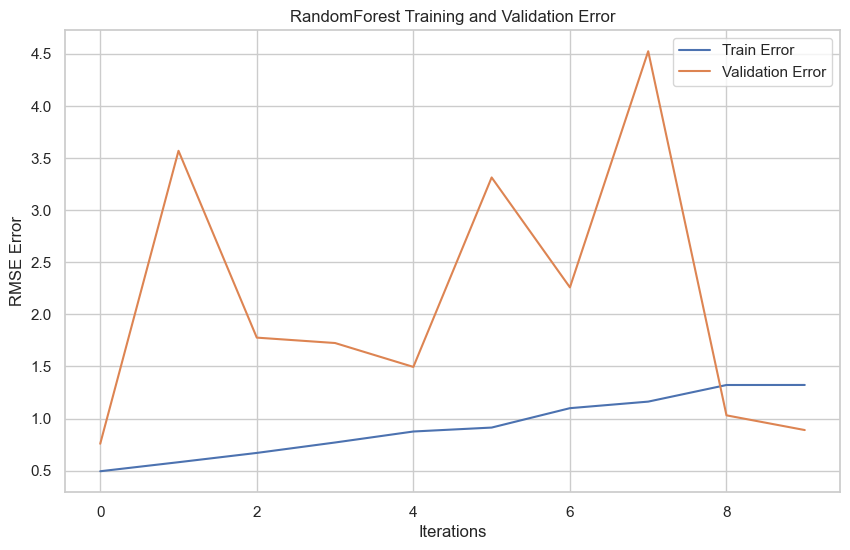

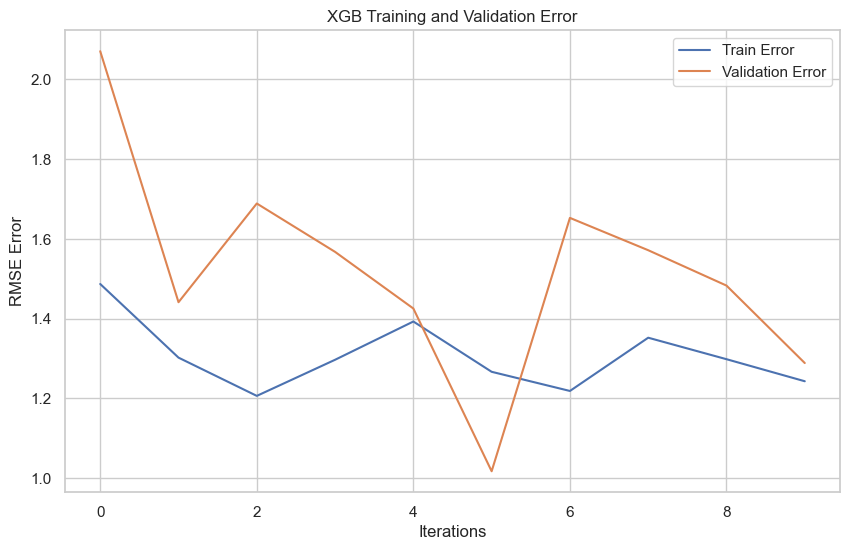

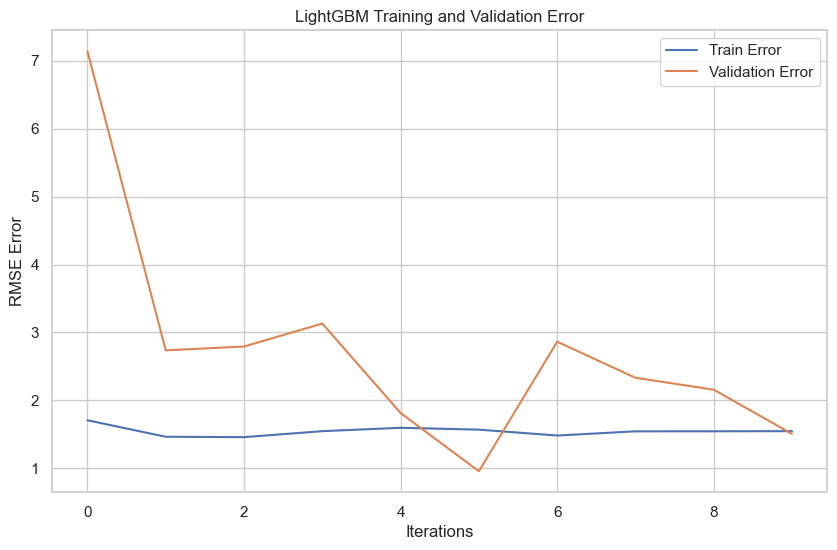

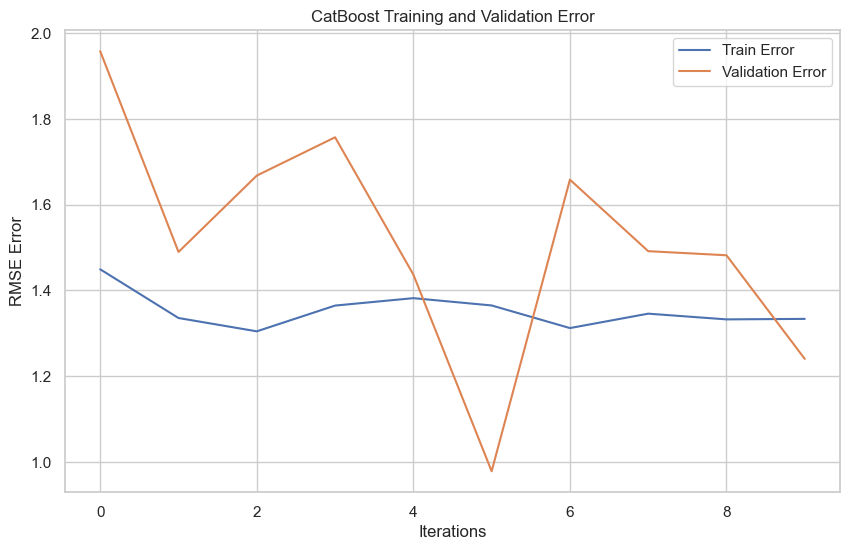

In [30]:
for model in df.columns:
    temp = df[model].reset_index()
    train_error = temp[temp.RMSE=='train_error'].iloc[:, 2].values
    val_error = temp[temp.RMSE=='validation_error'].iloc[:, 2].values

    plt.figure(figsize=(10, 6))
    plt.plot(train_error, label='Train Error')
    plt.plot(val_error, label='Validation Error')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE Error')
    plt.legend()
    plt.title(f'{model} Training and Validation Error')
    plt.show()

### Save submission results

In [22]:
submission_data = {
    'RF_submission' : RandomForest_regression_submission,
    'XGB_submission' : XGB_regression_submission,
    'LightGBM_submission' : LightGBM_regression_submission,
    'CatBoost_submission' : CatBoost_regression_submission
}

In [23]:
%%time
# add path to load 
path_to_load = Path("C:\Repository\DS-Intership-data") / "baseline_submissions"
os.makedirs(path_to_load, exist_ok=True)

# write data
for filename, df in submission_data.items():
    filepath = path_to_load / (filename + ".csv")
    with open(filepath, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(df)

CPU times: total: 15.6 ms
Wall time: 7 ms


In [24]:
from os import listdir
from os.path import isfile, join
print(*[f+"\n" for f in listdir(path_to_load) if isfile(join(path_to_load, f))])

CatBoost_submission
 LightGBM_submission
 RF_submission
 XGB_submission



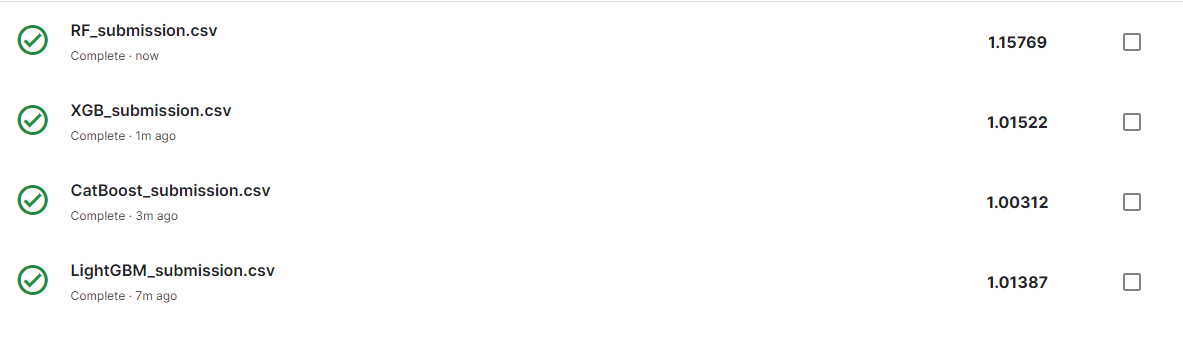